In [1]:
from __future__ import print_function, division
#run
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\\Users\\Lenovo\\Downloads\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\apple'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
x=len(class_names)
class_names

['Tomato___Blight',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___healthy',
 'Tomato_powdery_Mildew']

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


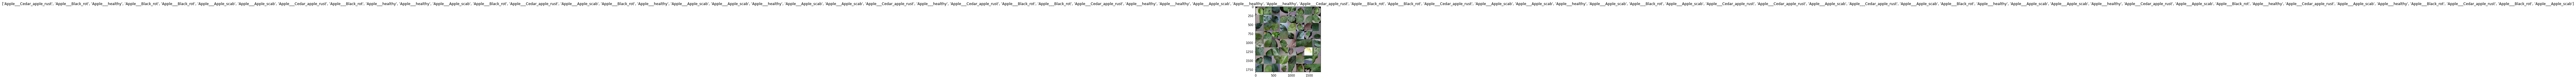

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    num=0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts,'/content/drive/MyDrive/Models/model_tomato'+str(num)+'.pt')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
x

4

In [2]:
model_ft = models.efficientnet_b1(pretrained=True)
model_ft.classifier[1]=nn.Sequential(nn.Linear(1280,512),nn.Linear(512,out_features=4))
# model_ft.fc = nn.Linear(num_ftrs, 4)
print(model_ft)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to C:\Users\Lenovo/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-533bc792.pth
100%|██████████| 30.1M/30.1M [00:03<00:00, 10.1MB/s]


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

NameError: name 'device' is not defined

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.8)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10 )
torch.save(model_ft,'./model_apple10.pt')


Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.0932 Acc: 0.9743
valid Loss: 0.0825 Acc: 0.9835

Epoch 1/9
----------
train Loss: 0.0897 Acc: 0.9756
valid Loss: 0.0771 Acc: 0.9861

Epoch 2/9
----------
train Loss: 0.0931 Acc: 0.9748
valid Loss: 0.0741 Acc: 0.9882

Epoch 3/9
----------
train Loss: 0.0864 Acc: 0.9767
valid Loss: 0.0708 Acc: 0.9876

Epoch 4/9
----------
train Loss: 0.0888 Acc: 0.9774
valid Loss: 0.0847 Acc: 0.9846

Epoch 5/9
----------
train Loss: 0.0891 Acc: 0.9749
valid Loss: 0.0891 Acc: 0.9825

Epoch 6/9
----------
train Loss: 0.0831 Acc: 0.9792
valid Loss: 0.0686 Acc: 0.9866

Epoch 7/9
----------
train Loss: 0.0838 Acc: 0.9785
valid Loss: 0.0738 Acc: 0.9851

Epoch 8/9
----------
train Loss: 0.0820 Acc: 0.9786
valid Loss: 0.0752 Acc: 0.9866

Epoch 9/9
----------
train Loss: 0.0931 Acc: 0.9745
valid Loss: 0.0712 Acc: 0.9861

Training complete in 8m 7s
Best val Acc: 0.988163


In [ ]:
!nvidia-smi
import torch, gc
gc.collect()

torch.cuda.empty_cache()
!nvidia-smi

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


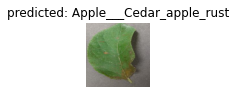

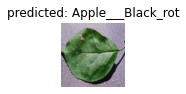

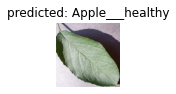

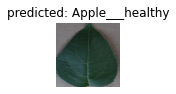

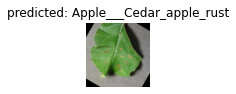

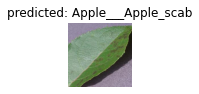

In [ ]:

visualize_model(model_ft)

In [ ]:
torch.save(model_ft,'./model_tomato10_5_10_5.pt')

In [ ]:
# model_conv = torchvision.models.resnet50(pretrained=True)
# for param in model_conv.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 4)

# model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that only parameters of final layer are being optimized as
# # opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25)

In [ ]:
# torch.save(model_conv,'./modelR50.pt')
# visualize_model(model_conv)

# plt.ioff()
# plt.show()

In [ ]:
#run


In [ ]:
pred_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
model=torch.load('/content/model_grape10_10.pt')


In [ ]:
from IPython.core.display import Image
import PIL.Image as Image
def classify(model,image_transform,img_path,class_names):
  model=model.eval()
  image=Image.open(img_path)
  image=image_transform(image).float()
  image = image.to("cuda")
  image=image.unsqueeze(0)
  out=model(image)
  _,pred=torch.max(out.data,1)
  print(class_names[pred.item()])

In [ ]:
classify(model_ft,pred_transforms,'/content/spot13.jpg',class_names)

NameError: ignored

In [ ]:
# model=torch.load("model_grape.pt")
# class_names=['Tomato___Bacterial_spot',
#  'Tomato___Early_blight',
#  'Tomato___Late_blight',
#  'Tomato___Leaf_Mold',
#  'Tomato___Septoria_leaf_spot',
#  'Tomato___Spider_mites Two-spotted_spider_mite',
#  'Tomato___Target_Spot',
#  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
#  'Tomato___Tomato_mosaic_virus',
#  'Tomato___healthy']
# classify(model,pred_transforms,'/content/download (9).jpg',classes)
classify(model,pred_transforms,'/content/images (6).jpg',class_names)


Grape___Leaf_blight_(Isariopsis_Leaf_Spot)


In [ ]:
# !nvidia-smi

In [ ]:
# !sudo fuser -v /dev/nvidia*

In [ ]:
# !sudo kill -9 73